<a href="https://colab.research.google.com/github/AbhayMudgal/PD_prediction/blob/main/Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr, spearmanr

from tensorflow import keras as K
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [102]:
data = pd.read_csv("Train_set.csv")
test = pd.read_csv("Test_set.csv")
data.columns

Index(['ID', 'loan_amnt', 'loan_term', 'interest_rate', 'loan_grade',
       'loan_subgrade', 'job_experience', 'home_ownership', 'annual_income',
       'income_verification_status', 'loan_purpose', 'state_code',
       'debt_to_income', 'delinq_2yrs', 'public_records', 'revolving_balance',
       'total_acc', 'interest_receive', 'application_type', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit', 'default'],
      dtype='object')

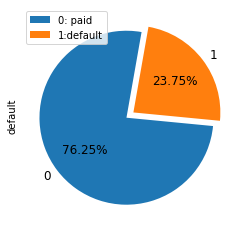

In [103]:
data.default.value_counts().plot(kind = 'pie', autopct='%1.2f%%', subplots = True, explode = (0.05, 0.05), startangle = 80, legend = True, fontsize = 12)
plt.legend(['0: paid', '1:default'])
plt.show()

In [104]:
#General Functions. Input string containing column name.
def stats(x):
    # basic statistics about a column.
    print(f"Variable: {x}")
    print(f"Type of variable: {data[x].dtype}")
    print(f"Total observations: {data[x].shape[0]}")
    detect_null_val = data[x].isnull().values.any()
    if detect_null_val:
        print(f"Missing values: {data[x].isnull().sum()} ({(data[x].isnull().sum() / data[x].isnull().shape[0] *100).round(2)}%)")
    else:
        print(f"Missing values? {data[x].isnull().values.any()}")
    print(f"Unique values: {data[x].nunique()}")
    if data[x].dtype != "O":
        print(f"Min: {int(data[x].min())}")
        print(f"25%: {int(data[x].quantile(q=[.25]).iloc[-1])}")
        print(f"Median: {int(data[x].median())}")
        print(f"75%: {int(data[x].quantile(q=[.75]).iloc[-1])}")
        print(f"Max: {int(data[x].max())}")
        print(f"Mean: {data[x].mean()}")
        print(f"Std dev: {data[x].std()}")
        print(f"Variance: {data[x].var()}")
        print(f"Skewness: {scipy.stats.skew(data[x])}")
        print(f"Kurtosis: {scipy.stats.kurtosis(data[x])}")
        print("")
        
        # Percentiles 1%, 5%, 95% and 99%print("Percentiles 1%, 5%, 95%, 99%")
        display(data[x].quantile(q=[.01, .05, .95, .99]))
        print("")
    else:
        print(f"List of unique values: {data[x].unique()}")

def segregated_counts(x):
  #plots a bar graph of the column against the unique values of default.
  zero = data[data.default == 0].loc[:, x]
  one = data[data.default == 1].loc[:, x]

  a = np.array(zero)
  b = np.array(one)

  #zero.value_counts().plot(kind = 'pie', autopct='%1.2f%%', subplots = True,legend = True, fontsize = 12) 
  #plt.title('Non-Defaults', loc = 'right')  
  #plt.show()
  
  #one.value_counts().plot(kind = 'pie', autopct='%1.2f%%', subplots = True,legend = True, fontsize = 12)  
  #plt.title('Defaults', loc = 'right')  
  #plt.show()

  np.warnings.filterwarnings('ignore')

  plt.hist(a, bins = 40, label = 'Non Default', align = 'left')
  plt.hist(b, bins = 40, align = 'right', label = "Default")

  plt.legend(loc = 'upper right')
  plt.title(x, loc = 'right')
  plt.xlabel('relative frequency')
  plt.ylabel('absolute frequency')
  plt.show()

def boxhist(x):
  # plots the boxplot + histogram of the data column
  column = data[x]

  mean = np.array(column).mean()
  median = np.median(column)

  f, (box, hist) = plt.subplots(2, sharex = True, gridspec_kw={"height_ratios": (0.5, 2)})

  sns.boxplot(column, ax = box)
  box.axvline(mean, color = 'r', linestyle = "--")
  box.axvline(median, color = 'g', linestyle = '-')

  sns.histplot(column, ax = hist)
  hist.axvline(mean, color = 'r', linestyle = "--")
  hist.axvline(median, color = 'g', linestyle = '-')

  plt.title(x, loc = 'right')
  plt.legend({'Mean':mean, 'Median': median})
  plt.xlabel("")
  plt.show()

def hist(x):
  #plots the histogram of the data column
  plt.hist(data[x], bins = 40)
  plt.title(x, loc = 'right')
  plt.xlabel("Relative Frequency")
  plt.ylabel("Absolute Frequency")
  plt.show()

def dist(x):
  #plots the histogram of the data column
  sns.distplot(data[x], bins = 40)
  plt.title(x, loc = 'right')
  plt.xlabel("Relative Frequency")
  plt.ylabel("Absolute Frequency")
  plt.show()

def pie(x):
  #plots a pie chart of the distribution of column values
  data[x].value_counts(dropna = False).plot(kind = 'pie', autopct='%1.1f%%', startangle = 0, legend = True)

def bar(x):
  #plots a vertical bar graph of the data
  ax = data[x].value_counts().plot(kind = 'bar', color = sns.color_palette('rocket'))
  for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width()/2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
  
  plt.xlabel(x, fontsize = 10)
  plt.xticks(rotation = 0, horizontalalignment = 'center')
  plt.ylabel("Absolute Values", fontsize = 10)
  plt.title(x, loc = 'right')
  plt.show()

def pivot_mean(a, b, c):
  #
  type_pivot_mean = data.pivot_table(cloumns = a, index = b, values = c, aggfunc = np.mean)
  display(type_pivot_mean)

  type_pivot_mean.sort_values(by = [b], ascending = True).plot(kind='bar', title = (b))

def pivot_sum(a, b, c):
  #
  type_pivot_sum = data.pivot_table(columns = a, index = b, values=c, aggfunc = np.sum)
  display(type_pivot_sum)

  type_pivot_sum.sort_values(by = [b], ascending = True).plot(kind='bar', title = (b))

def scatter(x, y):
  #plots a scatter plot of the data
  targets = data.default.unique()
  for target in targets:
    a = data[data.default == target][x]
    b = data[data.default == target][y]
    plt.scatter(a, b, label = f"Default: {target}", marker = '*')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.show()


In [105]:
print(data.dtypes.value_counts())

float64    11
object      7
int64       5
dtype: int64


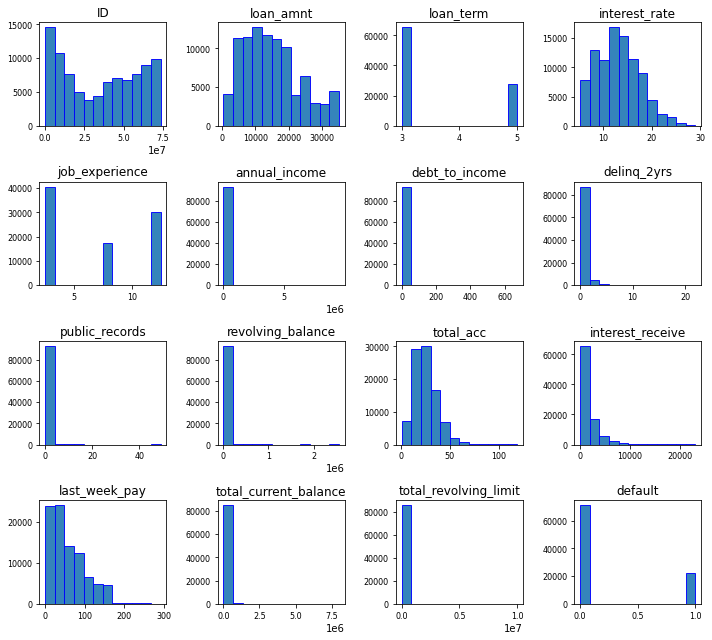

In [106]:
data.hist(figsize=(10,9), bins=12, ec="b", xlabelsize=8, ylabelsize=8, alpha=0.9, grid=False)
plt.tight_layout()
plt.show()

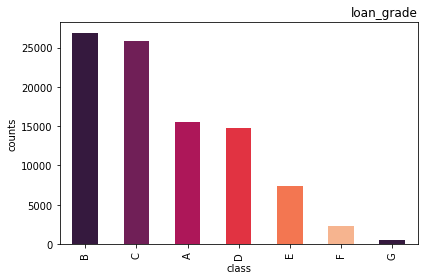

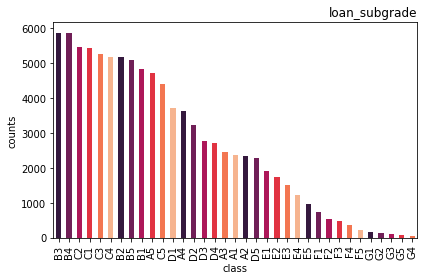

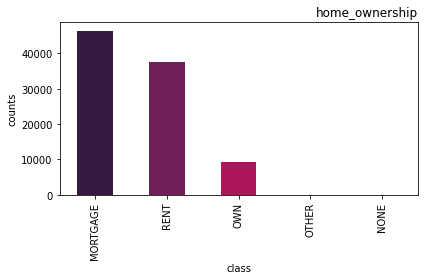

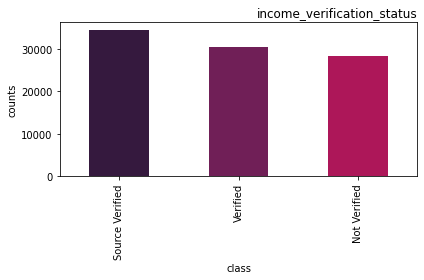

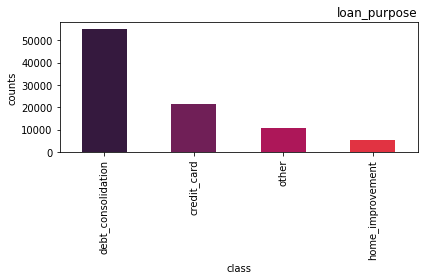

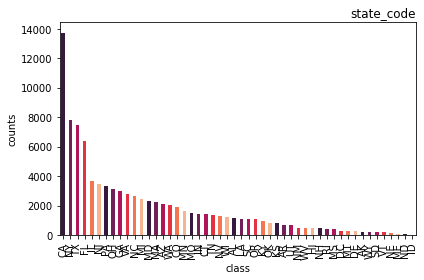

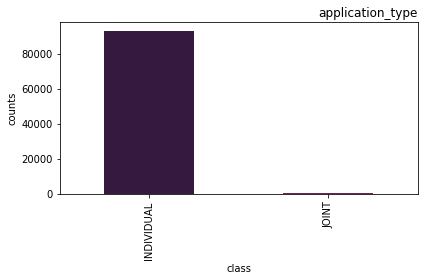

In [107]:
for col in data.select_dtypes(include = ['object']).columns:
  data[col].value_counts().plot(kind = 'bar', color = sns.color_palette("rocket"))
  plt.xlabel('class')
  plt.xticks(rotation=90, horizontalalignment="center")
  plt.ylabel("counts")
  plt.title(col, loc = "right")
  plt.tight_layout()
  plt.show()

Variable: loan_amnt
Type of variable: int64
Total observations: 93174
Missing values? False
Unique values: 1310
Min: 500
25%: 8000
Median: 13000
75%: 20000
Max: 35000
Mean: 14733.861377637539
Std dev: 8428.184857775183
Variance: 71034299.99683088
Skewness: 0.6865786755872716
Kurtosis: -0.24864155691902257



0.01     1800.0
0.05     3600.0
0.95    32000.0
0.99    35000.0
Name: loan_amnt, dtype: float64

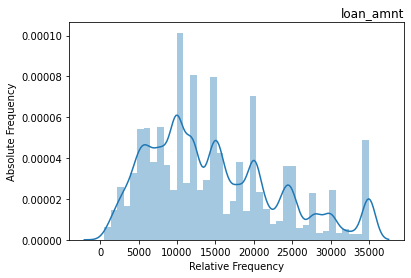

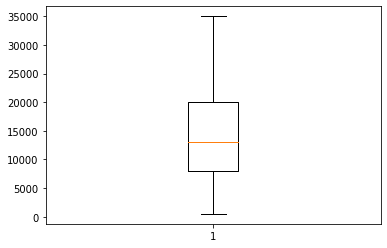

In [108]:
# loan_amnt col check.
stats('loan_amnt')
plt.tight_layout()
dist('loan_amnt')
plt.boxplot(data.loan_amnt)
plt.show()

Variable: annual_income
Type of variable: float64
Total observations: 93174
Missing values: 1 (0.0%)
Unique values: 8667
Min: 1200
25%: 45000
Median: 64000
75%: 90000
Max: 9500000
Mean: 75028.25855880998
Std dev: 69454.78399405701
Variance: 4823967019.661118
Skewness: nan
Kurtosis: nan



0.01     19000.0
0.05     28000.0
0.95    150000.0
0.99    250000.0
Name: annual_income, dtype: float64

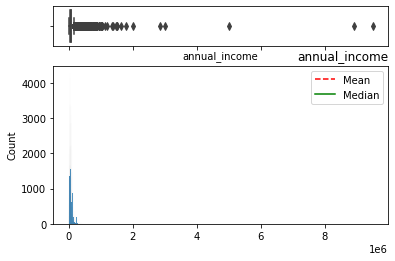

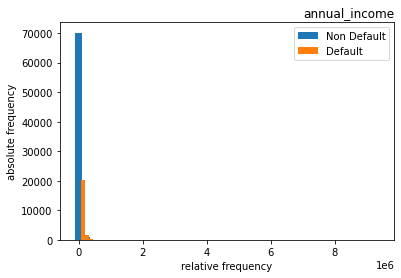

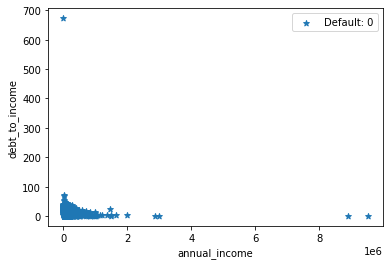

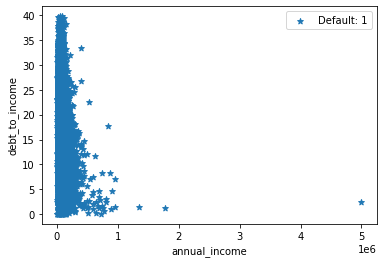

In [109]:
# annual_income col check
stats("annual_income")
boxhist("annual_income")
segregated_counts("annual_income")
scatter("annual_income", "debt_to_income")

Variable: interest_rate
Type of variable: float64
Total observations: 93174
Missing values? False
Unique values: 481
Min: 5
25%: 9
Median: 12
75%: 16
Max: 28
Mean: 13.233433146585094
Std dev: 4.368728219239771
Variance: 19.085786253581905
Skewness: 0.42601752603362036
Kurtosis: -0.16172067234518384



0.01     5.32
0.05     6.62
0.95    20.99
0.99    24.83
Name: interest_rate, dtype: float64

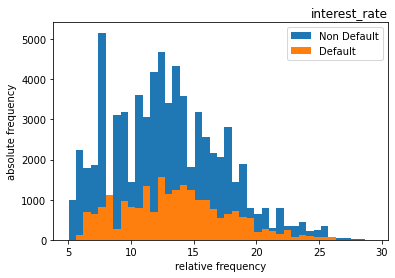

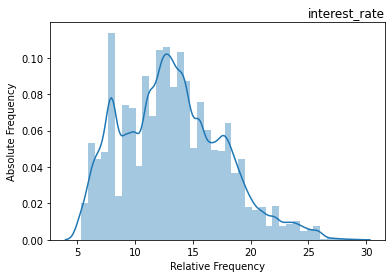

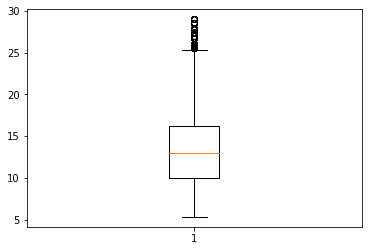

In [110]:
# interest_rate col check
stats("interest_rate")
segregated_counts("interest_rate")
dist("interest_rate")
plt.boxplot(data.interest_rate)
plt.show()

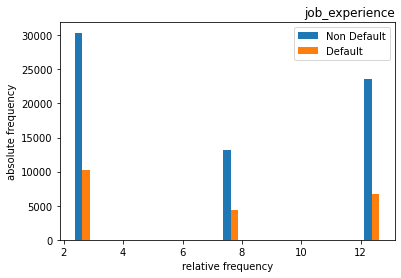

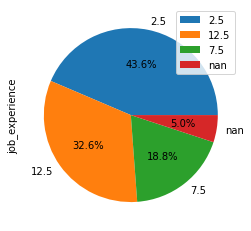

In [111]:
#job_experience col check
segregated_counts('job_experience')
pie('job_experience')

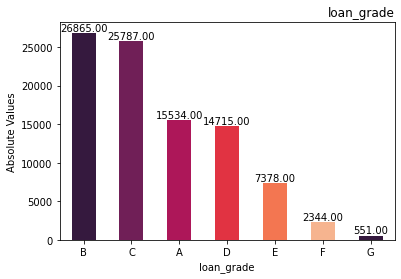

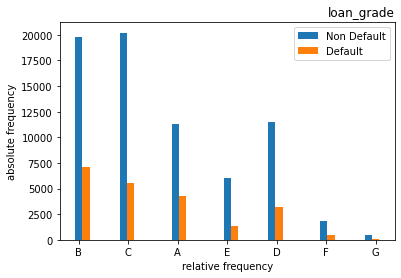

In [112]:
#loan_grade col check
bar("loan_grade")

segregated_counts("loan_grade")

Variable: home_ownership
Type of variable: object
Total observations: 93174
Missing values? False
Unique values: 5
List of unique values: ['OWN' 'MORTGAGE' 'RENT' 'NONE' 'OTHER']


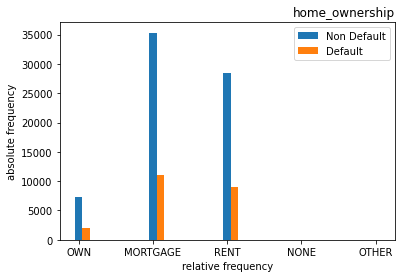

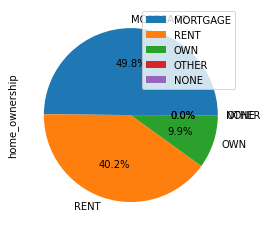

In [113]:
#home_ownership col check
stats("home_ownership")
segregated_counts("home_ownership")
pie("home_ownership")


Variable: income_verification_status
Type of variable: object
Total observations: 93174
Missing values? False
Unique values: 3
List of unique values: ['Not Verified' 'Verified' 'Source Verified']


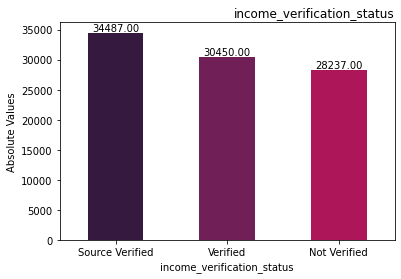

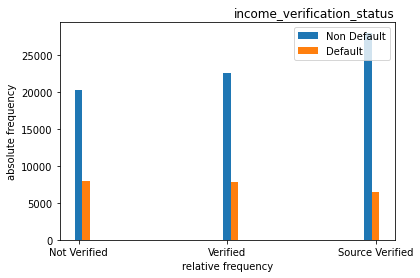

In [114]:
#income_verification_status
stats("income_verification_status")
bar("income_verification_status")
segregated_counts("income_verification_status")

Variable: debt_to_income
Type of variable: float64
Total observations: 93174
Missing values? False
Unique values: 3996
Min: 0
25%: 11
Median: 17
75%: 23
Max: 672
Mean: 18.127622727370277
Std dev: 8.563084091842356
Variance: 73.32640916396362
Skewness: 5.005605888960648
Kurtosis: 365.25250744156517



0.01     1.9900
0.05     5.2100
0.95    32.7135
0.99    37.4800
Name: debt_to_income, dtype: float64

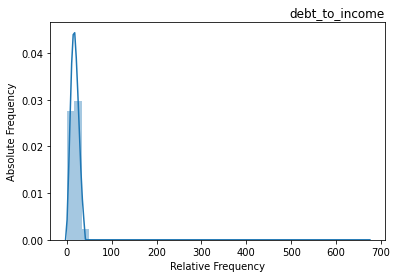

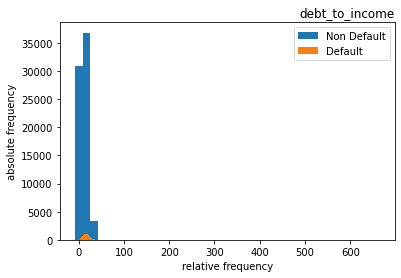

home_ownership,MORTGAGE,NONE,OTHER,OWN,RENT
loan_purpose,,,,,
credit_card,192825.10,88.57,109.32,43722.23,158372.32
debt_consolidation,511138.81,17.23,66.33,99753.60,425418.10
home_improvement,65086.76,NaN,5.95,12001.12,6168.71
other,68510.67,4.00,70.68,20477.67,85185.95


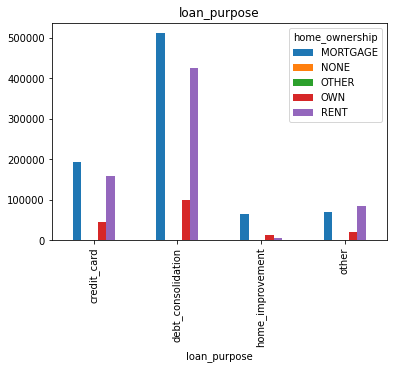

In [115]:
#debt_to_income
stats("debt_to_income")
dist("debt_to_income")
segregated_counts("debt_to_income")
pivot_sum("home_ownership", "loan_purpose", "debt_to_income")

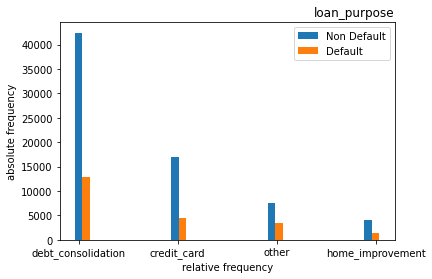

In [116]:
#loan_purpose
segregated_counts("loan_purpose")

Variable: delinq_2yrs
Type of variable: float64
Total observations: 93174
Missing values: 2 (0.0%)
Unique values: 22
Min: 0
25%: 0
Median: 0
75%: 0
Max: 22
Mean: 0.3169943759927875
Std dev: 0.8808591237433078
Variance: 0.775912795881828
Skewness: nan
Kurtosis: nan



0.01    0.0
0.05    0.0
0.95    2.0
0.99    4.0
Name: delinq_2yrs, dtype: float64

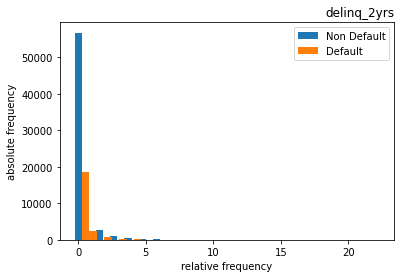

In [117]:
stats("delinq_2yrs")
segregated_counts("delinq_2yrs")

Variable: last_week_pay
Type of variable: float64
Total observations: 93174
Missing values: 1924 (2.06%)
Unique values: 90
Min: 0
25%: 22
Median: 48
75%: 83
Max: 291
Mean: 58.15488219178082
Std dev: 44.3265603786523
Variance: 1964.8439550023081
Skewness: nan
Kurtosis: nan



0.01      4.0
0.05      4.0
0.95    152.0
0.99    165.0
Name: last_week_pay, dtype: float64

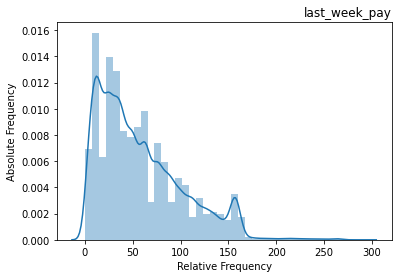

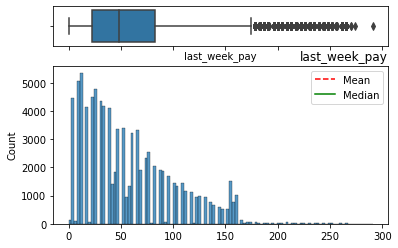

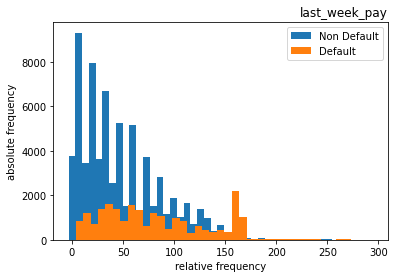

In [118]:
stats("last_week_pay")
dist("last_week_pay")
boxhist("last_week_pay")
segregated_counts("last_week_pay")

In [119]:
le = LabelEncoder()
encode = ["loan_grade", 'loan_subgrade', 'home_ownership', 'loan_purpose', 'income_verification_status', 'application_type']

for col in encode:
  le.fit(data[col])
  data[col] = le.transform(data[col])
  test[col] = le.transform(test[col])

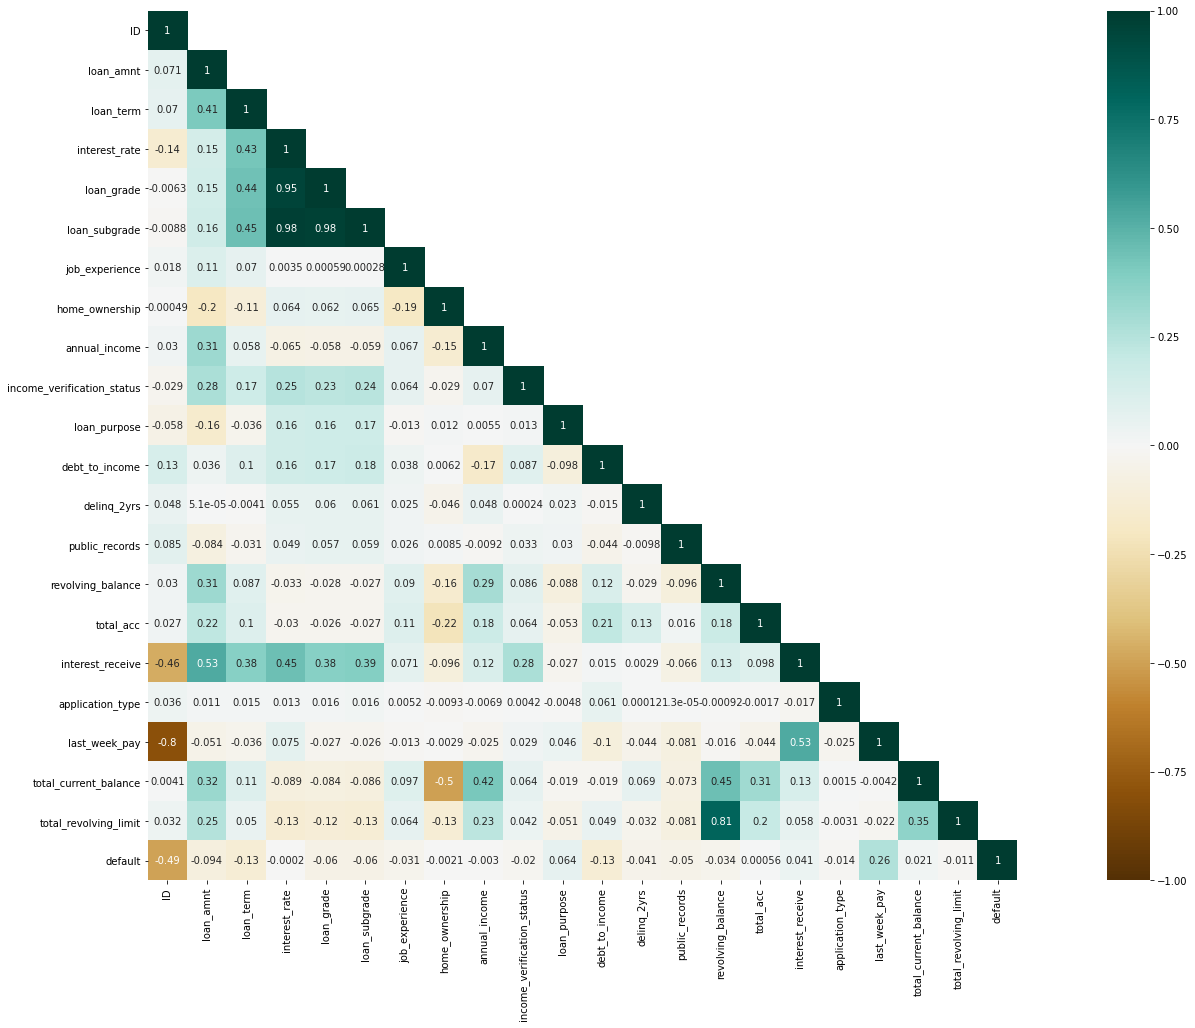

In [120]:
mask = np.triu(data.corr(), 1)
plt.figure(figsize=(32, 16))
sns.heatmap(data.corr(), annot=True, vmax=1, vmin=-1, square=True, cmap='BrBG', mask=mask);

In [121]:
test.shape


(39933, 22)

In [122]:
print("Train: \n", data.isna().sum(), "\n\n")
print("Test: \n", test.isna().sum())

Train: 
 ID                               0
loan_amnt                        0
loan_term                        0
interest_rate                    0
loan_grade                       0
loan_subgrade                    0
job_experience                4702
home_ownership                   0
annual_income                    1
income_verification_status       0
loan_purpose                     0
state_code                       0
debt_to_income                   0
delinq_2yrs                      2
public_records                   2
revolving_balance                0
total_acc                        2
interest_receive                 0
application_type                 0
last_week_pay                 1924
total_current_balance         7386
total_revolving_limit         7386
default                          0
dtype: int64 


Test: 
 ID                               0
loan_amnt                        0
loan_term                        0
interest_rate                    0
loan_grade            

In [123]:
#We see a strong correlation between total_revolving_limit and revolving_balance.
#As such it would be a good approximation to drop the revolving limit column
#which has a large number of missing values. We also drop the weekly coorelated total
#current balance. We drop loan subgrade too.

data.drop(['total_revolving_limit', 'total_current_balance', 'loan_subgrade', 'state_code'], axis = 1, inplace = True)
test.drop(['total_revolving_limit', 'total_current_balance', 'loan_subgrade', 'state_code'], axis = 1, inplace = True)

In [124]:
# Dealing with NaN values in the data.
# Due to uncertainity, NaN values in job experience are replaced with 0.
# NaN in last_week_pay are replaced with the mean of the column
# Left over NaN values are removed using ffill

mean = data.last_week_pay.mean()
data.last_week_pay.fillna(mean, inplace = True)
test.last_week_pay.fillna(mean, inplace = True)

data.job_experience.fillna(0, inplace = True)
test.job_experience.fillna(0, inplace = True)

data.fillna(method = 'ffill', inplace = True)
test.fillna(method = 'ffill', inplace = True)

Variable: loan_amnt
Type of variable: int64
Total observations: 93174
Missing values? False
Unique values: 1310
Min: 500
25%: 8000
Median: 13000
75%: 20000
Max: 35000
Mean: 14733.861377637539
Std dev: 8428.184857775183
Variance: 71034299.99683088
Skewness: 0.6865786755872716
Kurtosis: -0.24864155691902257



0.01     1800.0
0.05     3600.0
0.95    32000.0
0.99    35000.0
Name: loan_amnt, dtype: float64

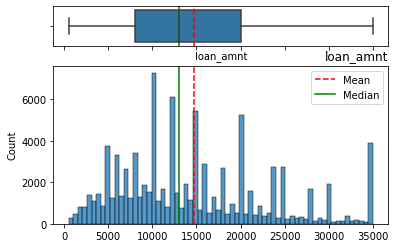

Variable: annual_income
Type of variable: float64
Total observations: 93174
Missing values? False
Unique values: 8667
Min: 1200
25%: 45000
Median: 64000
75%: 90000
Max: 9500000
Mean: 75028.63389679526
Std dev: 69454.50576874889
Variance: 4823928371.581172
Skewness: 56.669988202960724
Kurtosis: 6800.564414861989



0.01     19000.0
0.05     28000.0
0.95    150000.0
0.99    250000.0
Name: annual_income, dtype: float64

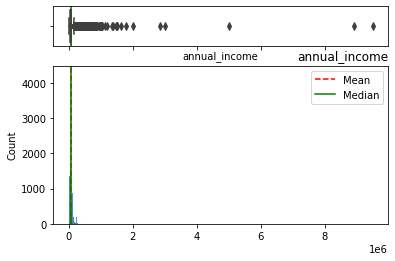

Variable: debt_to_income
Type of variable: float64
Total observations: 93174
Missing values? False
Unique values: 3996
Min: 0
25%: 11
Median: 17
75%: 23
Max: 672
Mean: 18.127622727370277
Std dev: 8.563084091842356
Variance: 73.32640916396362
Skewness: 5.005605888960648
Kurtosis: 365.25250744156517



0.01     1.9900
0.05     5.2100
0.95    32.7135
0.99    37.4800
Name: debt_to_income, dtype: float64

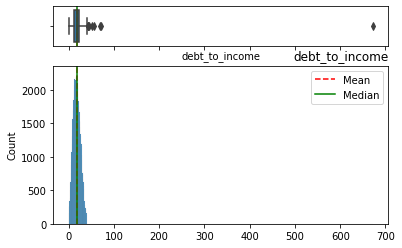

Variable: total_acc
Type of variable: float64
Total observations: 93174
Missing values? False
Unique values: 102
Min: 1
25%: 17
Median: 24
75%: 32
Max: 119
Mean: 25.24894283813081
Std dev: 11.854980919432114
Variance: 140.5405726000995
Skewness: 0.8927399850884553
Kurtosis: 1.2503002289886798



0.01     6.0
0.05     9.0
0.95    47.0
0.99    61.0
Name: total_acc, dtype: float64

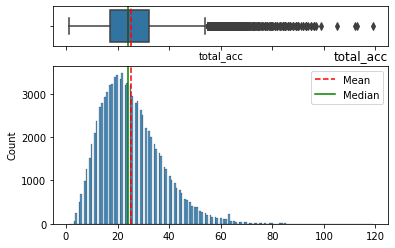

Variable: revolving_balance
Type of variable: int64
Total observations: 93174
Missing values? False
Unique values: 35945
Min: 0
25%: 6433
Median: 11856
75%: 20745
Max: 2560703
Mean: 16854.468510528688
Std dev: 23689.073886828803
Variance: 561172221.6156342
Skewness: 24.716653611579023
Kurtosis: 1873.6117358685453



0.01      281.00
0.05     2006.65
0.95    43453.10
0.99    91892.08
Name: revolving_balance, dtype: float64

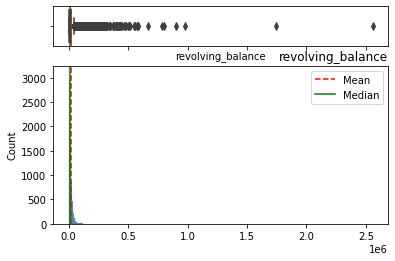

In [125]:
Outlier_check = ['loan_amnt', 'annual_income', 'debt_to_income', 'total_acc', 'revolving_balance']
for col in Outlier_check:
  stats(col)
  boxhist(col)

In [126]:
# removing outliers in the columns.
outlier_removal = ["annual_income", 'debt_to_income', "total_acc", 'revolving_balance']

def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
      
    print("IQR value for column %s is: %s" % (col, IQR))
    global outlier_free_list
    global filtered_data
      
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if (
        (x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]

    

for col in outlier_removal:
  removeOutliers(data, col)
  data = filtered_data

IQR value for column annual_income is: 45000.0
IQR value for column debt_to_income is: 11.909999999999998
IQR value for column total_acc is: 16.0
IQR value for column revolving_balance is: 13489.0


In [127]:
def transform(a, b):
  # min max transform for a column in test and train sets
  mi = min(a)
  ma = max(a)

  for i in range(len(a)):
    a.iloc[i] = (a.iloc[i] - mi)/(ma - mi)

  for i in range(len(b)):
    b.iloc[i] = (b.iloc[i] - mi)/(ma - mi)

  return a, b;
  
to_transform = ["loan_amnt", 'interest_rate', 'annual_income', 'revolving_balance', 'total_acc', 'interest_receive', 'last_week_pay']

for col in to_transform:
  data[col], test[col] = transform(data[col], test[col])


In [129]:
categorical_list = ['loan_term', 'loan_grade', 'application_type', 'job_experience', 'home_ownership', 'loan_purpose', 'income_verification_status']
data = pd.get_dummies(data, columns = ['loan_term', 'loan_grade', 'application_type', 'job_experience', 'home_ownership', 'loan_purpose', 'income_verification_status'])
test = pd.get_dummies(test, columns = categorical_list)

In [134]:
#creating test and train sets.
y = data['default']
data.drop(['default'], axis = 1, inplace = True)

X = data.to_numpy()
Y = y.to_numpy()
X_sub = test.to_numpy()

x_train, x_test, y_train,  y_test = train_test_split(X, Y, test_size = 0.2)
print(x_train.shape, y_train.shape, X_sub.shape)

(66458, 38) (66458,) (39933, 38)


In [ ]:
NN_model = K.Sequential([
      K.layers.Dense(128, input_shape = (38,), activation='relu'),
      K.layers.Dense(16, activation='relu'),
      K.layers.Dense(1, activation='sigmoid')                 
])

model.summary()

opt = K.optimizers.SGD(learning_rate = 0.1)

model.compile(optimizer = opt, loss = 'mean_squared_error', metrics = ['accuracy'])
history = model.fit(X, y, epochs = 25, validation_split = 0.15)